# Project Goal
 
* Discover drivers of customer churn at Telco.
* Use drivers to develop a machine learning model that accurately predicts churn. 

## Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

from scipy import stats

import env
import wrangle as w
import explore as e
import modeling as m

## Acquire

- Data acquired from CodeUp databse
- It contained 7,043 rows and 22 columns before cleaning
- Each row represents a telco customer
- Each column represents a feature of the customer

## Prepare
#### Prepare Actions:

- Removed redundant or unusefull columns
- Checked for nulls in the data, found 11 null values in 1 column. Due to low proportion of data, I dropped these rows.
- Convert the data type of the total charges column to reflect/use the data properly
- Split data into train, validate and test (approx. 60/25/15), with proportions based on the Churn column

### Data Dictionary

| Feature | Definition |
|:--------|:-----------|
|Gender| The gender of the primary account holder|
|Senior Citizen| True or False, is the primary account holder 62 years or age or older|
|Partner| Yes or No, does the primary account holder have a partner in the household|
|Dependants| Yes or No, does the primary account holder have at least 1 dependent in the household|
|Tenure| The time in years the primary account holder has been a customer|
|Phone Service| Yes or No, does the primary account holder have phone service with Telco|
|Multiple Lines| Yes or No, does the primary account holder have multiple lines with Telco|
|Internet Service Type ID|  **1** (DSL), **2** (Fiber Optic), **3** (None)
|Tech Support| Yes or No, Has the client contacted tech support|
|Contract Type ID|  **1** (Month-to-Month), **2** (One-Year), **3** (Two-Year)|
|Payment Type ID| **1** (Electronic Check), **2** (Mailed Check), **3** (Automatic Bank Transfer), **4** (Credit Card)|
|Monthly Charges| Monthly bill assesed to the cusotmer|
|Total Charges| Total revenue paid by the cusotmer|
|Churn| Yes or No, has the customer stopped doing business with us|

In [2]:
# acquire & clean the data
df = w.wrangle_telco_data()

# split the data into train, validate, and test subsets
train, validate, test = w.split_my_data(df)

### A breif look at our data:

In [3]:
train.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,tech_support,contract_type_id,payment_type_id,monthly_charges,total_charges,churn
0,Male,0,No,No,48,Yes,Yes,2,No,3,3,108.10,5067.45,No
1,Male,0,Yes,Yes,63,Yes,Yes,3,No internet service,3,2,25.25,1573.05,No
2,Male,0,Yes,No,52,Yes,No,1,No,2,2,75.40,3865.45,No
3,Male,0,Yes,No,72,Yes,Yes,2,Yes,3,4,109.75,7758.90,No
4,Male,1,Yes,No,72,No,No phone service,1,Yes,3,4,64.45,4641.10,No


### A summary of the charges:

In [4]:
train[['monthly_charges', 'total_charges']].describe().round(2)

,monthly_charges,total_charges
count,3937.00,3937.00
mean,64.27,2265.81
std,30.13,2267.40
min,18.25,18.80
25%,34.95,385.00
50%,70.00,1367.75
75%,89.65,3777.15
max,118.65,8684.80


## Explore

### What proportion of customers have churned?

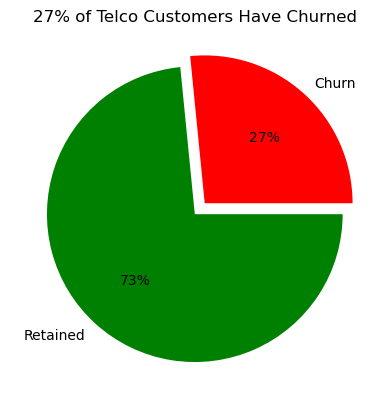

In [5]:
e.get_pie_churn(train)

    - Telco has a 73% retention rate overall

### What proportion of churned customers are senior citizens?

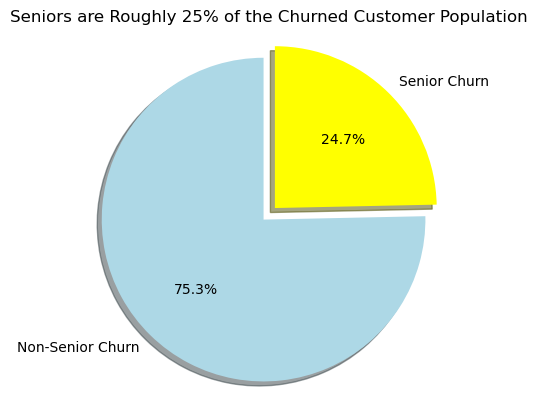

In [6]:
e.get_pie_sen_churn(train)

    - We see almost 26% of the churned customers are seniors, are they over-represented here?

### How does the proportion of churned seniors compare to the observed population?

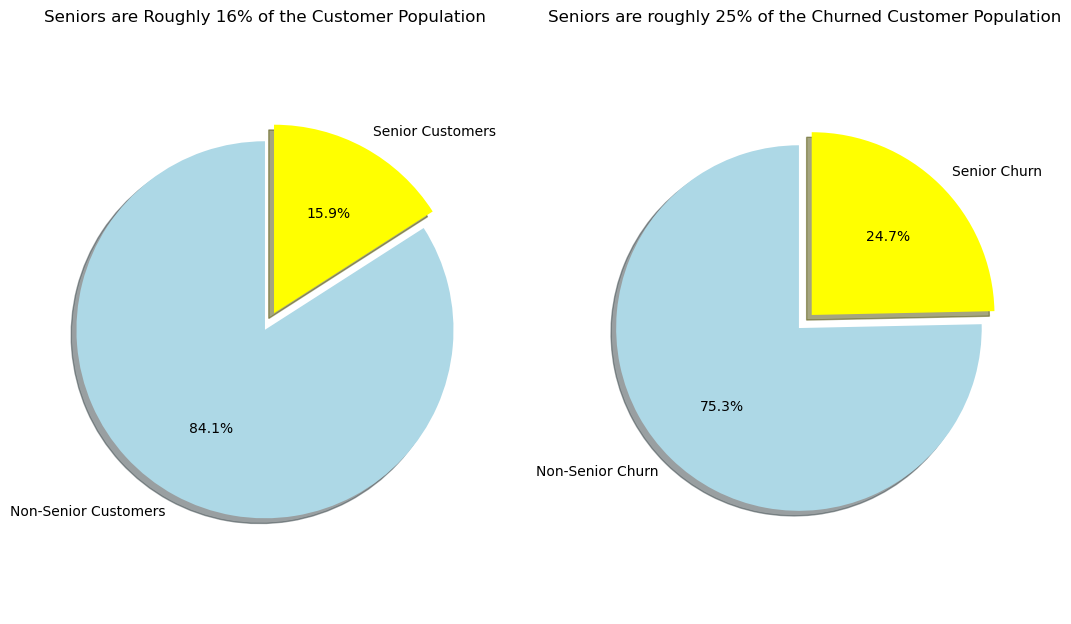

In [7]:
e.get_pie_sen_compared(train)

    - We see that the senior churn rate is disproportional to the population.

##### Lets use a chi-square test to see if Churn and Senior Citizen status are related

- I will use a confidence interval of 95%
- The resulting alpha is .05

##### Ho: 'churn' and 'senior_citizen' are independent of one another.
##### Ha: 'churn and 'senior_citizen' are related.

In [8]:
e.get_chi_senior(train)

chi2 = 80.3711
p     = 0.00000000


Technically, a p value cannot truly be 0. Statistically speaking, we can very confidently reject the null hypothesis as our evidence supports a small probability that their relationship is due to chance. Based on the p value of this calculation and the clear disproportion of churned customers being senior citizens, we can be confident that senior citizen status is a key feature we need to investigate concerning churn.

### Does Monthly Charges Effect Churn?

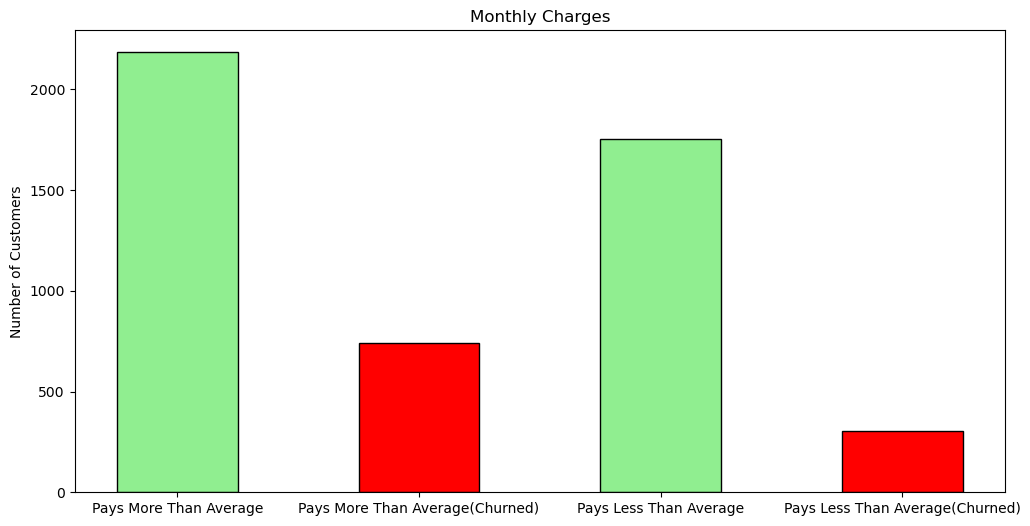

In [9]:
e.get_bar_charges(train)

    - Here we see a visualization of customers who pay more or less than the mean on a monthly basis. Approximately 35% of customers paying more than the average monthly charges churn, compared to only roughly 16% that churned and were paying less than the averege monthly charges

##### Are monthy charges of customers who churn significantly different than customers who do not churn?

I will perform an Independent t-test to calculate a tstat and p-value comparing monthly charges of customers who churn and those who do not.

- I will use a confidence interval of 95%
- The resulting alpha is .05

##### H0: Mean of monthly charges of churned customers <= Mean of monthly charges of customers who haven't churned
##### Ha: Mean of monthly charges of churned customers > Mean of monthly charges of customers who haven't churned

In [10]:
e.charges_churn_tstat(train)

t-stat = 13.2803
p     = 0.0000


Because p/2 is less than our alpha of .05, we fail to reject the null hypothesis that churned customers are paying less than or equal to customers who have not.  Based on the support of confidence in our alternate hypothesis from this test, and the higher rate of churn where monthly charges are above average, we can be confident that monthly charges are a key feature we need to investigate concerning churn.

### Could access to Tech Support be a factor of churn?

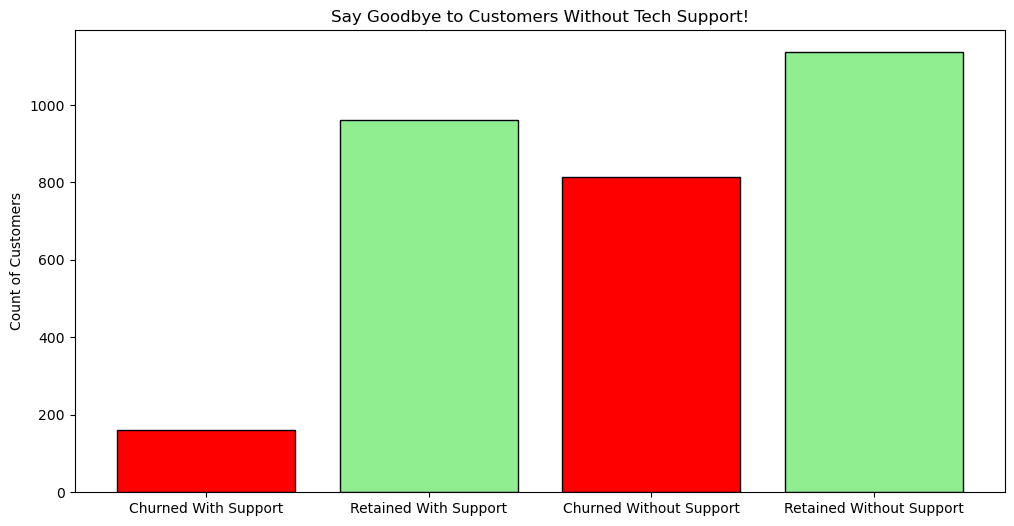

In [11]:
e.get_bar_support(train)

    - Approximately 15% of customers with tech support churn, compared to over 41% of customers without 
    tech support churn. 

##### I will now use a chi-square test to investigate weather Churn and Tech Support are related.

I will use a confidence interval of 95%
The resulting alpha is .05

##### Ho: Churn and Tech Support are independent of one another.
##### Ha: Churn and Tech Support are related.

In [12]:
e.get_chi_techsupp(train)

chi^2 = 468.6607
p     = 0.00000000


In a chi square test, if p < alpha, there exists some relationship between the two groups. Since our p value is much lower and close to 0, we can confidently reject the null hypothesis that churn and tech support are independent of one another. Based on the resuults of this calculation and the dispropotion of churn in customers without tech support, we can be confident this is a major driver of churn among senior citizens. 

## Exploration Summary

- 27% of customers have churned
- Senior citizens churn at a dipropotional rate compared to non-seniors
- Chi square test promotes confidence in the relationship of churn and senior citizens
- Customers are more likey to churn if they pay monthly charges above the mean 
- Our independent t test supported confidence that monthly charges is a driver in customer churn
- Customers without tech support churn at a much higher rate than those with tech support
- Our chi square test backs up this theory, showing confidence in a relationship between churn and tech support

## Features I will use in modeling:

- Senior Citizen status (over representented in churn population, stong statistical relation)
- Monthly Charges (churned customers were paying more than the mean, t test supports this)
- Tech Support (customers without support churn at a very high rate, stong statistical relation)


## Modeling

I will use accuracy as my evaluation method. Accuracy is the number of times we predicted correctly divided by the total number of observations

Churn makes up 27% of the data

* By guessing no churn for every customer, we have a baseline accuracy of 73%. 

* I will be evaluating models developed using four different model types, Decision Tree, Random Forest, KNN & Logistic Regression 

* Models will be evaluated on the train and validate data sets

* The model that performs the best will then be evaluated on test data set

In [13]:
# prep data for modeling
train_X, train_y, validate_X, validate_y, test_X, test_y = m.model_prep(train,validate,test)

## Decision Tree

In [14]:
m.dec_tree_acc(train_X, validate_X, train_y, validate_y)

Decision Tree accuracy on train data: 0.7495554991109982
Decision Tree accuracy on validate data: 0.7156398104265402


    - Decision Tree accuracy is about even with the baseline accuracy (~73%)

## Random Forest

In [15]:
m.ran_forest_acc(train_X, validate_X, train_y, validate_y)

Random Forest accuracy on train data: 0.7421894843789688
Random Forest accuracy on validate data: 0.7209715639810427


    - Random Forest accuracy is about even with the baseline accuracy (~73%)

## Logistic Regression

In [16]:
m.log_reg_acc(train_X, validate_X, train_y, validate_y)

Logistic Regression accuracy on train data: 0.7239014478028956
Logistic Regression accuracy on validate data: 0.6706161137440758


    - Logistic Regression accuracy is about even with the baseline accuracy (~73%) but worse on the validate set

## K Nearest Neighbor

In [17]:
m.knn_acc(train_X, validate_X, train_y, validate_y)

KNN accuracy on train: 0.8468376936753873
KNN accuracy on on validate: 0.6208530805687204


        - KNN accuracy of the train set is greater than baseline accuracy (~73%) but worse on the validate set. It          is likely over-fit

## Model Comparision:

- Decision Tree and Randon Forest both performed about as well as the baseline of ~73%
- Logistic Regression performed the worst, with an accuracy score lower than baseline on the train set, and much lower on validate.
- KNN looks overfit, as it performed better than the baseline accuracy on the train set, but much worse on the validate set.
- I could proceed with either Decision Tree of Logistic regression, I will use Random Forest because it has a slightly less spread in accuarcy score between the train and validate sets

## Random Forest on test set:

In [18]:
m.ran_forest_test(train_X, test_X, train_y, test_y)

Random Forest accuracy on test data: 0.7213930348258707
